# Report: AIS Vessel Trajectory Prediction

## Exploratory Data Analysis

### Domain knowledge
AIS is a short range tracking system that transmits ships positions using the high frequency maritime frequency band. It was originally developed as a collision avoidance tool. Each ship transmits a signal containing vessel identity, position, speed and course to surrounding ships and shore stations. The position of the ship is obtained by either using the ships GPS signal or an inertial sensor built into the AIS unit. Static information is sent every sixth minute or at request the ship sends MMSI number, IMO number, name and call sign, length and beam, type of ship and location of position fixing antenna. Dynamic information is sent dependent on the speed and course alterations of the ship. The dynamic information consist of Ships position, accuracy indication, position timestamp and the course over ground. 

It is mandatory for all ships above 300 GT (gross tonnage) to carry AIS, and it is illegal to turn it of. All 300 GT boats mus carry a class A AIS system, while other boats like pleasure crafts can carry a class B AIS system with limited functionality. 

The signals are sensible to noise and enviromental disturbances. Making AIS unpredictable. Some relevant factors are signal propagation conditions, sea state, the height of antennas and strength of the transmitter. These factors giva a large variation in signal transmition length from 20-350 nautical miles. But an average of 40 nautical miles can safely be expected.

### Data intuitition

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import median_filter
import plotly.express as px
import plotly.graph_objects as go

In [3]:
train = pd.read_csv('../datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])

Heading is given in angular degrees from north from 0 deg to 359 deg. It is also quite noisy and could use filtering first. 

In [4]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Example: Applying a moving average filter
window_size = 5  # You can adjust the window size based on the level of smoothing you need

def exponential_moving_average(data, alpha):
    ema = [data[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[i - 1])
    return np.array(ema)

# Example: Applying EMA
alpha = 0.3  # Smoothing factor (0 < alpha <= 1)

def low_pass_filter(data, cutoff_freq, sampling_rate):
    fft_data = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data), d=1/sampling_rate)
    
    # Zero out frequencies higher than the cutoff
    fft_data[np.abs(frequencies) > cutoff_freq] = 0
    
    # Inverse FFT to get the filtered signal
    return np.fft.ifft(fft_data)

# Example: Applying a low-pass filter
cutoff_frequency = 0.1  # Define the cutoff frequency
sampling_rate = 1  # Define the sampling rate (based on time intervals of data)

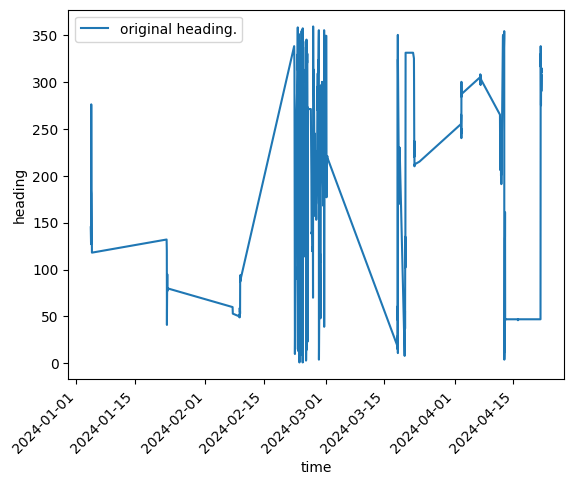

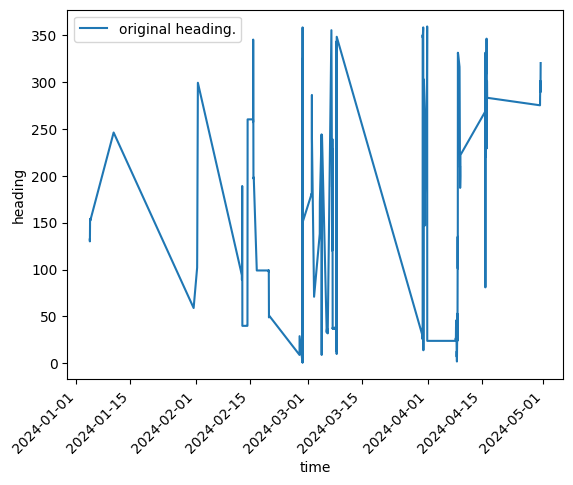

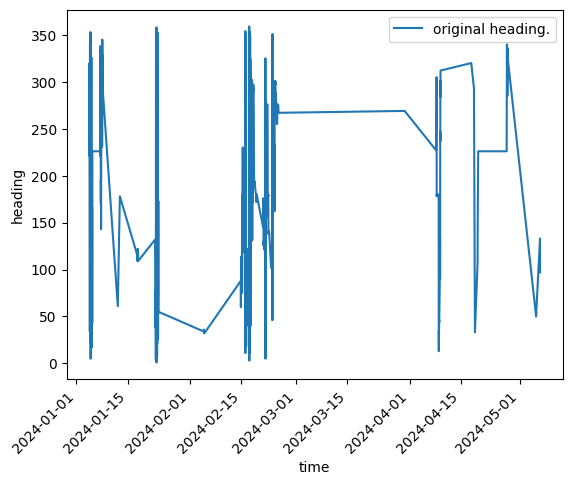

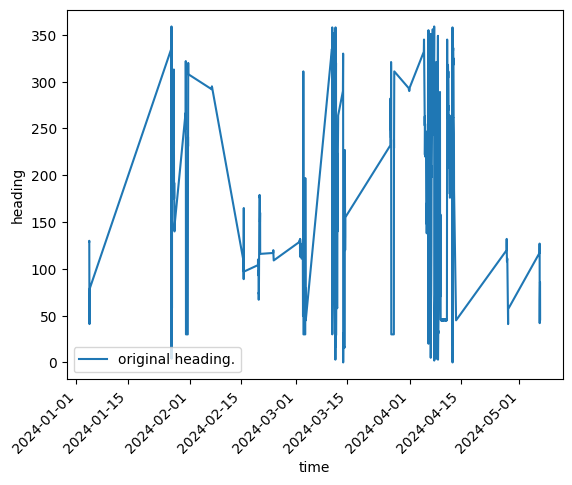

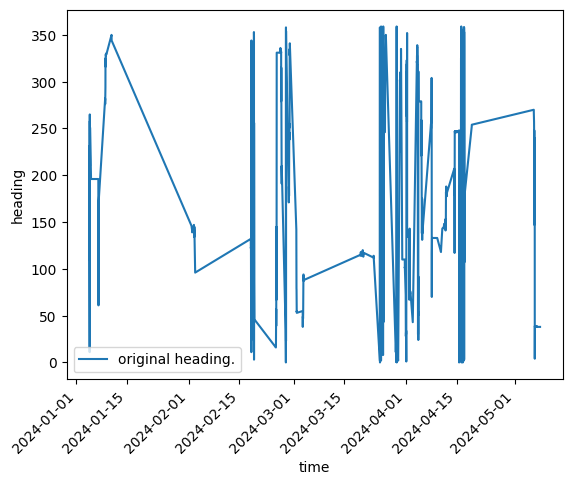

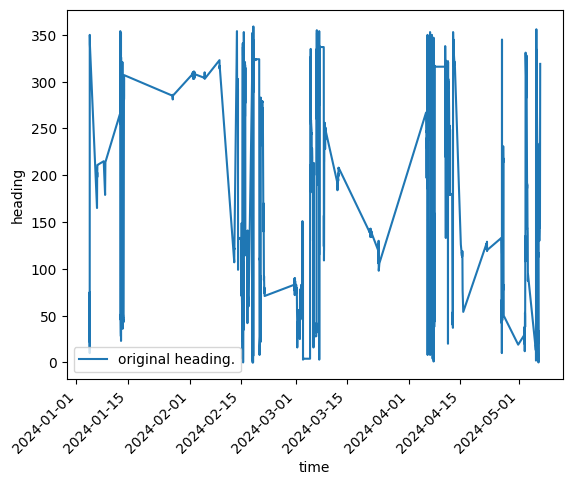

In [5]:
vesselID = train['vesselId'].unique()

for i in range(6):
    dataPoints = train[train['vesselId'] == vesselID[i+400]]
    x = range(len(dataPoints))
    sns.lineplot(x=dataPoints['time'], y=dataPoints['heading'], label=f'original heading.')
    
    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')  # Adjust rotation and horizontal alignment ('ha')
    
    # Show the plot
    plt.show()


There is a spread in how many samples there are in each timeslot. The AIS should be periodically and it should have the same number within each timeslot. There is also a big difference in the number of samples between the different ships. There is also huge gaps between each sequence of AIS data. Could split up each ship in continous slots where AIS is available. Seems like it spams AIS data when they are stationary. 

The cog measurement is really noisy.



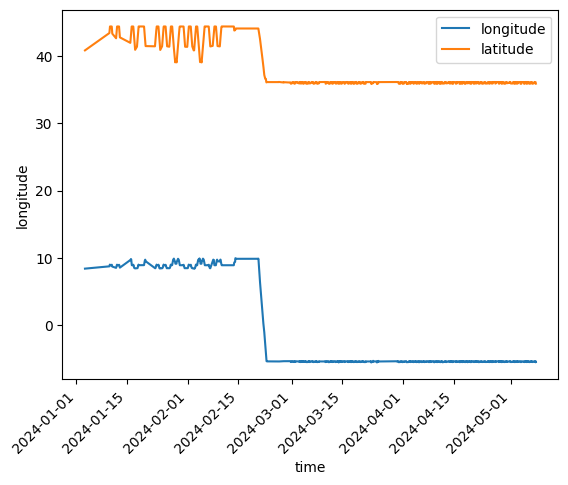

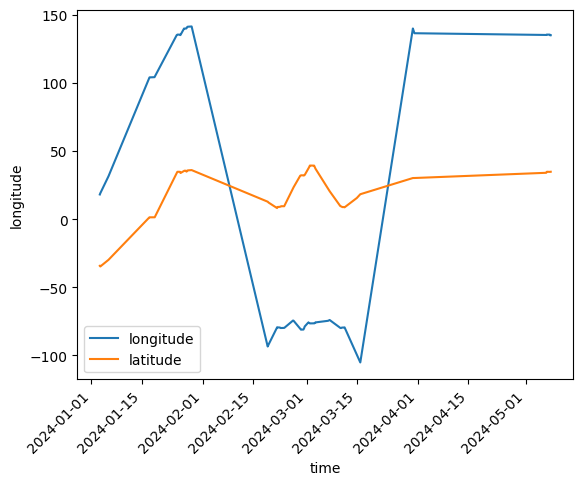

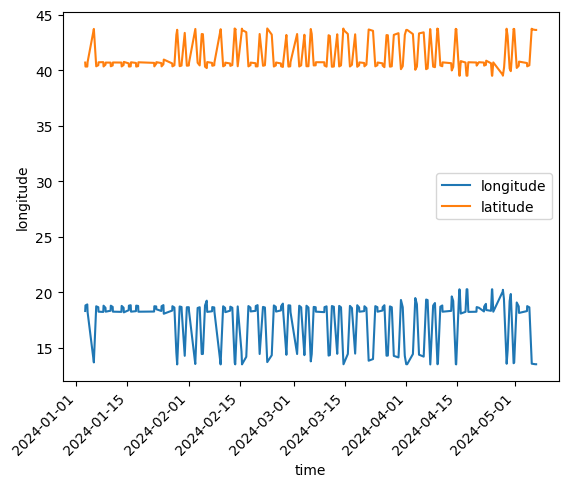

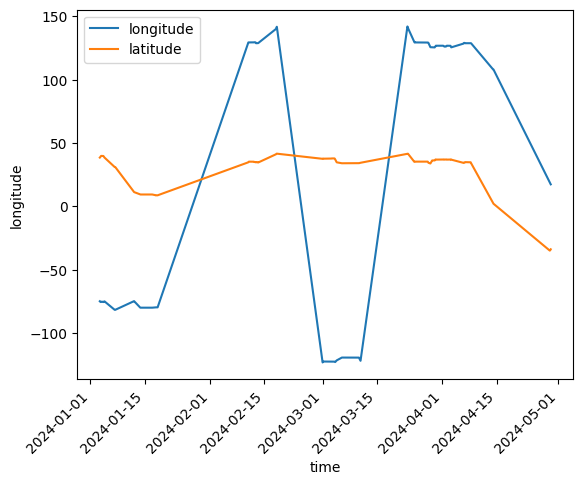

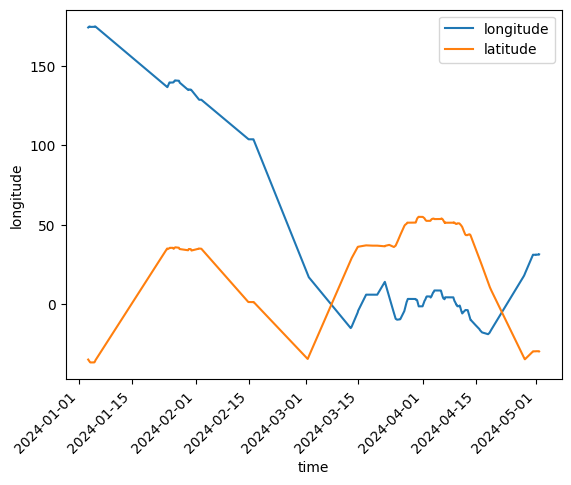

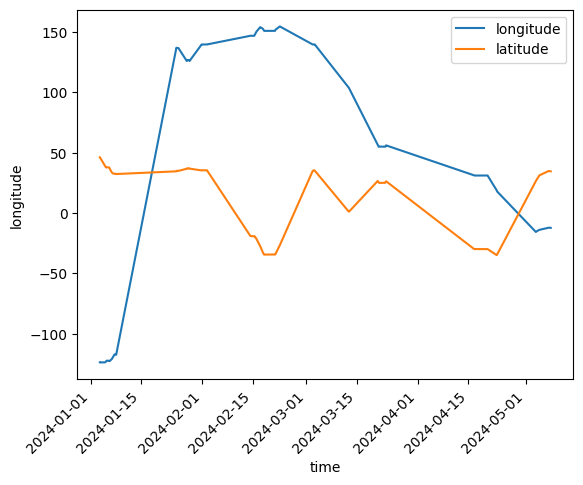

In [6]:
# Add is moored feature
train['isMoored'] = train['navstat']== 5

#remove latitude and longditude measurment if moored
#train.loc[train['isMoored'], ['longitude', 'latitude']] = np.nan
#train = train[~train['isMoored']]

vesselID = train['vesselId'].unique()

for i in range(6):
    dataPoints = train[train['vesselId']== vesselID[i+350]]
    x = range(len(dataPoints))
    sns.lineplot(x=dataPoints['time'], y=dataPoints['longitude'], label='longitude')
    sns.lineplot(x=dataPoints['time'], y=dataPoints['latitude'], label='latitude')
    # sns.lineplot(x=x, y=median_filter(dataPoints['heading'], window_size), label='median filter')
    # sns.lineplot(x=x, y=low_pass_filter(dataPoints['heading'], cutoff_frequency, sampling_rate), label='low pass filter')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')  # Adjust rotation and horizontal alignment ('ha')
    plt.show()

In [10]:
def visualize_vessel_movements(train):
    """
    Visualize vessel movements on a map with lines and markers for each data point.

    Parameters:
    - df (pandas.DataFrame): A DataFrame with columns ['time', 'latitude', 'longitude', 'vesselId'].

    Returns:
    - A Plotly interactive figure.
    """
    # Ensure 'time' is in datetime format for better tooltip handling
    df['time'] = pd.to_datetime(df['time'])
    
    # Sorting the DataFrame by time to ensure lines are drawn correctly
    df = df.sort_values(by=['vesselId', 'time'])

    # Define a color palette
    color_map = px.colors.qualitative.Plotly

    # Mapping each vessel ID to a color
    unique_vessels = df['vesselId'].unique()
    colors = {vessel_id: color_map[i % len(color_map)] for i, vessel_id in enumerate(unique_vessels)}

    # Create the base map with lines
    fig = px.line_geo(df,
                      lat='latitude',
                      lon='longitude',
                      color='vesselId',
                      color_discrete_map=colors,
                      hover_name='vesselId',
                      hover_data={'time': True, 'latitude': ':.3f', 'longitude': ':.3f'},
                      projection='natural earth',
                      title='Vessel Movements Over Time')

    # Add markers for each data point
    for vessel_id in unique_vessels:
        vessel_data = df[df['vesselId'] == vessel_id]
        fig.add_trace(go.Scattergeo(
            lon=vessel_data['longitude'],
            lat=vessel_data['latitude'],
            mode='markers',
            marker=dict(
                size=8,
                color=colors[vessel_id],
                opacity=0.8,
                line=dict(width=1, color='DarkSlateGrey')
            ),
            name=f'Markers for {vessel_id}',
            hoverinfo='text',
            text=vessel_data.apply(lambda row: f'ID: {vessel_id}<br>Time: {row["time"]}<br>Lat: {row["latitude"]:.3f}<br>Lon: {row["longitude"]:.3f}', axis=1)
        ))

    # Enhancing map and layout details
    fig.update_geos(fitbounds="locations", showcountries=True, countrycolor="RebeccaPurple")
    fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0},
                      coloraxis_colorbar=dict(title="Vessel ID"),
                      title_font_size=20)
    
    return fig

In [9]:
for i in range(6):
    dataPoints = train[train['vesselId']== vesselID[i+350]]
    fig = visualize_vessel_movements(dataPoints)
    fig.show()

C:\Users\marvaar\AppData\Local\Temp\ipykernel_14792\699849566.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


C:\Users\marvaar\AppData\Local\Temp\ipykernel_14792\699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\marvaar\AppData\Local\Temp\ipykernel_14792\699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\marvaar\AppData\Local\Temp\ipykernel_14792\699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\marvaar\AppData\Local\Temp\ipykernel_14792\699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\marvaar\AppData\Local\Temp\ipykernel_14792\699849566.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Data generation

## Predictors

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

filepath_train = '../datasets/ais_train.csv'
filepath_test = '../datasets/ais_test.csv'

# Load AIS historical data
train = pd.read_csv(filepath_train, sep ='|')  # Replace with your dataset
test = pd.read_csv(filepath_test, sep = ',')

# Preprocessing
train['time'] = pd.to_datetime(train['time'])
train.sort_values(by=['vesselId', 'time'], inplace=True)
train['isMoored'] = train['navstat']== 5
# Why are we using the complement?
train = train[~train['isMoored']]

test['time'] = pd.to_datetime(test['time'])
test.sort_values(by=['vesselId', 'time'], inplace=True)

print(f"Length of dataframe before dropna: {len(train)}")
# Drop rows with missing values
# Here, we can fill in with mean instead
train.dropna(inplace=True)

print(f"Length of dataframe after dropna: {len(train)}")

# Find the index of the earliest timestamp for each vesselId
earliest_idx = train.groupby('vesselId')['time'].idxmin()

print(f"Length before dropping earliest: {len(train)}")

# Drop the rows with the earliest timestamp for each vessel
train = train.drop(earliest_idx).reset_index(drop=True)

Length of dataframe before dropna: 916234
Length of dataframe after dropna: 915925
Length before dropping earliest: 915925
Length after dropping earliest: 915239


In [38]:
import pandas as pd

# Example DataFrame
data = {'vesselId': [12345, 12345, 12345, 67890, 67890],
        'time': ['2024-01-01 10:00:00', '2024-01-01 12:00:00', '2024-01-01 14:00:00', 
                 '2024-01-02 08:00:00', '2024-01-02 10:00:00']}

df = pd.DataFrame(data)

# Convert 'time' to datetime if not already
df['time'] = pd.to_datetime(df['time'])

# Calculate the difference in time between the current and previous row
df['time_diff'] = df['time'].diff()

# If you want the difference in seconds (or any other unit)
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()

print(df)


   vesselId                time       time_diff  time_diff_seconds
0     12345 2024-01-01 10:00:00             NaT                NaN
1     12345 2024-01-01 12:00:00 0 days 02:00:00             7200.0
2     12345 2024-01-01 14:00:00 0 days 02:00:00             7200.0
3     67890 2024-01-02 08:00:00 0 days 18:00:00            64800.0
4     67890 2024-01-02 10:00:00 0 days 02:00:00             7200.0


In [55]:
# Extract feature importance
importances = model_lon.feature_importances_

# Display the feature importances along with their corresponding feature names
feature_names = X_lon_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance (optional)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(feature_importance_df)

NameError: name 'X_lon_train' is not defined

In [81]:
# X = train[['prev_lat', 'prev_lon', 'prev_speed', 'prev_course','prev_rotation', 'turn_info_available', 'prev_heading', 'time_diff_seconds', 'time']]
X.head(40)

,prev_lat,prev_lon,prev_speed,prev_course,prev_rotation,turn_info_available,prev_heading,time_diff_seconds
0,7.50361,77.58340,17.1,0.711667,-6.0,1,316.0,1393.0
1,7.57302,77.49505,17.3,0.708889,5.0,1,313.0,1583.0
2,7.65043,77.39404,16.9,0.704444,5.0,1,312.0,1285.0
3,7.71275,77.31394,16.9,0.710556,6.0,1,313.0,1259.0
4,7.77191,77.23585,16.3,0.705556,7.0,1,313.0,901.0
5,7.81285,77.18147,16.1,0.708889,5.0,1,313.0,1211.0
6,7.86929,77.11032,16.1,0.719444,-6.0,1,313.0,1225.0
7,7.92585,77.03811,16.0,0.715000,2.0,1,311.0,1200.0
8,7.98258,76.96880,16.0,0.724444,-1.0,1,311.0,1152.0
9,8.03598,76.90095,16.1,0.708333,6.0,1,307.0,1320.0


In [7]:
def days_to_secs(days):
    return days * 24 * 3600

In [17]:
# Parameters 
timedelta_threshold_days = 15

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

filepath_train = '../datasets/ais_train.csv'
filepath_test = '../datasets/ais_test.csv'

# Load AIS historical data
train = pd.read_csv(filepath_train, sep ='|')  # Replace with your dataset
test = pd.read_csv(filepath_test, sep = ',')

# Preprocessing
train['time'] = pd.to_datetime(train['time'])
train.sort_values(by=['vesselId', 'time'], inplace=True)
train['isMoored'] = train['navstat']== 5
# Why are we using the complement?
train = train[~train['isMoored']]

test['time'] = pd.to_datetime(test['time'])
test.sort_values(by=['vesselId', 'time'], inplace=True)

# Feature Engineering
train['prev_lat'] = train.groupby('vesselId')['latitude'].shift(1)
train['prev_lon'] = train.groupby('vesselId')['longitude'].shift(1)
train['prev_speed'] = train.groupby('vesselId')['sog'].shift(1)
train['prev_course'] = (train.groupby('vesselId')['cog'].shift(1) / 180) - 1        # normalized
train['prev_rotation'] = train.groupby('vesselId')['rot'].shift(1) 
train['prev_heading'] = (train.groupby('vesselId')['heading'].shift(1)/ 180) - 1 
train['hour'] = train['time'].dt.hour
# Could change this to is_weekend
train['day_of_week'] = train['time'].dt.dayofweek
# Adding timedelta as a feature
train['time_diff'] = train['time'].diff()
train['time_diff_seconds'] = train['time_diff'].dt.total_seconds()


# --------------------------------- prev_rot-related stuff
# Replace special values with NaN
train['prev_rotation'] = train['prev_rotation'].replace({127: np.nan, -127: np.nan, -128: np.nan})
# Optional: Create a new column for turn information availability
train['turn_info_available'] = np.where(train['prev_rotation'] == -128, 0, 1)

# Create binary columns for turn direction and magnitude
train['turn_direction'] = np.where(train['prev_rotation'] > 0, 'right', 'left')
train['turn_magnitude'] = train['prev_rotation'].abs()

# Fill missing values (optional, using forward fill) Uses most recent non-null value from the row above.
train['prev_rotation'].fillna(method='ffill', inplace=True)


rows_w_too_large_timedelta_idx = train[train['time_diff_seconds'] > days_to_secs(timedelta_threshold_days)].index.to_list()
earliest_idx = train.groupby('vesselId')['time'].idxmin().tolist()
idx_to_drop = rows_w_too_large_timedelta_idx + earliest_idx
train = train.drop(idx_to_drop).reset_index(drop=True)

# REMOVE THIS 
print(f"Rows with too high timedeltas: {len(rows_w_too_large_timedelta_idx)}")

# Drop rows with missing values
train.dropna(inplace=True)

# Define features and target variables
X = train[['prev_lat', 'prev_lon', 'prev_speed', 'prev_course','prev_rotation', 'turn_info_available', 'prev_heading', 'time_diff_seconds']]
y_lat = train['latitude']
y_lon = train['longitude']
X_test = test

X_lat_train, X_lat_val, y_lat_train, y_lat_val = train_test_split(X, y_lat, test_size=0.1, random_state=42)
X_lon_train, X_lon_val, y_lon_train, y_lon_val = train_test_split(X, y_lon, test_size=0.1, random_state=42)

# Train the model
model_lat = RandomForestRegressor(n_estimators=20, verbose=3, random_state=42)
model_lat.fit(X_lat_train.values, y_lat_train.values)

model_lon = RandomForestRegressor(n_estimators=20, verbose=3, random_state=42)
model_lon.fit(X_lon_train.values, y_lon_train.values)

# Make predictions on the validation set
y_lat_pred_val = model_lat.predict(X_lat_val)
y_lon_pred_val = model_lon.predict(X_lon_val)

# Evaluate performance on the validation set
mae_lat = mean_absolute_error(y_lat_val, y_lat_pred_val)
mae_lon = mean_absolute_error(y_lon_val, y_lon_pred_val)

print(f'Mean Absolute Error for Latitude: {mae_lat}')
print(f'Mean Absolute Error for Longitude: {mae_lon}')


C:\Users\marvaar\AppData\Local\Temp\ipykernel_15180\4014380975.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['prev_rotation'].fillna(method='ffill', inplace=True)
C:\Users\marvaar\AppData\Local\Temp\ipykernel_15180\4014380975.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['prev_rotation'].fillna(method='ffill', inplace=True)


Rows with too high timedeltas: 605
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


c:\Users\marvaar\Documents\tdt4173\venv_tdt4173\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\marvaar\Documents\tdt4173\venv_tdt4173\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Mean Absolute Error for Latitude: 0.06950002112165703
Mean Absolute Error for Longitude: 0.10205790969572574


In [19]:
# Load AIS historical data
training_data = pd.read_csv(filepath_train, sep ='|')  # Replace with your dataset

In [20]:
from datetime import datetime

# Predict future positions
def predict_future_position(id, vessel_id, time):
    # Fetch the latest known position of the vessel
    latest_data = training_data[training_data['vesselId'] == vessel_id].sort_values(by='time').iloc[-1]

    new_data = {
        'prev_lat': latest_data['latitude'],
        'prev_lon': latest_data['longitude'],
        'prev_speed': latest_data['sog'],
        'prev_course': (latest_data['cog'] / 180) - 1,
        'prev_rotation': latest_data['rot'],
        'turn_info_available': 1 if latest_data['rot'] != -128 else 0,
        'prev_heading' : (latest_data['heading'] / 180) - 1,

        # Convert the times to a datetime_obj
        'time_diff_seconds' : (datetime.strptime(time, '%Y-%m-%d %H:%M:%S') - datetime.strptime(latest_data['time'], '%Y-%m-%d %H:%M:%S')).total_seconds(),
    }
    # why is it done with all this list stuff?
    return id, model_lat.predict([list(new_data.values())])[0], model_lon.predict([list(new_data.values())])[0]
    # return id, model_lat.predict([list(new_data.values())]), model_lon.predict([list(new_data.values())]), new_data['time_diff_seconds'], latest_data['time']

# ['prev_lat', 'prev_lon', 'prev_speed', 'prev_course','prev_rotation', 'turn_info_available', 'prev_heading', 'time_diff_seconds']

In [160]:
with open('../predictions/predictions.csv', 'r') as f, open('../predictions/predictions_2.csv', 'w') as f_new:
    f_new.write("ID,longitude_predicted,latitude_predicted\n")
    for line in f.readlines()[1:]:
        id, lat, lon = line.split(',')
        f_new.write(f"{id},{float(lon)},{float(lat)}\n")

In [23]:
from tqdm import tqdm
# Open the test file for reading and the prediction file for writing
with open('../datasets/ais_test.csv', 'r') as f_test, open('../predictions/predictions.csv', 'w') as f_pred:
    f_pred.write("ID,longitude_predicted,latitude_predicted\n")
    for line in f_test.readlines()[1:]:
        id, vesselID, time, scaling_factor = line.split(',')
        id, pred_lat, pred_lon = predict_future_position(id, vesselID, time)
        f_pred.write(f"{id},{pred_lon},{pred_lat}\n")


In [139]:
# Load AIS historical data
training_data = pd.read_csv(filepath_train, sep ='|')  # Replace with your dataset
training_data[training_data['vesselId'] == '61e9f3aeb937134a3c4bfe3d'].sort_values(by='time').iloc[-1:]

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
1521883,2024-05-07 23:48:16,179.6,0.0,0,344,5,05-06 10:45,31.14647,-81.49789,61e9f3aeb937134a3c4bfe3d,61d38499b7b7526e1adf3d54


In [130]:
float_num = 0.129137128418742
print(f"And the number is: {float_num:.5f}")

And the number is: 0.12914


In [49]:
train.columns

Index(['cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId', 'isMoored', 'prev_lat', 'prev_lon',
       'prev_speed', 'prev_course', 'prev_rotation', 'prev_heading', 'hour',
       'day_of_week', 'time_diff_seconds'],
      dtype='object')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

filepath_train = '../datasets/ais_train.csv'
filepath_test = '../datasets/ais_test.csv'

# Load AIS historical data
train = pd.read_csv(filepath_train, sep ='|')  # Replace with your dataset
test = pd.read_csv(filepath_test, sep = ',')

# Preprocessing
train['time'] = pd.to_datetime(train['time'])
train.sort_values(by=['vesselId', 'time'], inplace=True)
train['isMoored'] = train['navstat']== 5
train = train[~train['isMoored']]

test['time'] = pd.to_datetime(test['time'])
test.sort_values(by=['vesselId', 'time'], inplace=True)


# Feature Engineering
# There will be some rows that does not make sense by doing it like this. Should probably drop these
train['prev_lat'] = train.groupby('vesselId')['latitude'].shift(1)
train['prev_lon'] = train.groupby('vesselId')['longitude'].shift(1)
train['prev_speed'] = train.groupby('vesselId')['sog'].shift(1)
train['prev_course'] = train.groupby('vesselId')['cog'].shift(1)
train['prev_rotation'] = train.groupby('vesselId')['rot'].shift(1)
train['prev_heading'] = train.groupby('vesselId')['heading'].shift(1)
train['hour'] = train['time'].dt.hour
train['day_of_week'] = train['time'].dt.dayofweek

# Drop rows with missing values
train.dropna(inplace=True)

# Define features and target variables
X_train = train[['prev_lat', 'prev_lon', 'prev_speed', 'prev_course','prev_rotation', 'hour', 'day_of_week', 'prev_heading']]
y_lat_train = train['latitude']
y_lon_train = train['longitude']
X_test = test



# Train the model
model_lat = RandomForestRegressor(n_estimators=100, random_state=42)
model_lat.fit(X_train, y_lat_train)

model_lon = RandomForestRegressor(n_estimators=100, random_state=42)
model_lon.fit(X_train, y_lon_train)

# Make predictions
y_pred_lat = model_lat.predict(X_test)
y_pred_lon = model_lon.predict(X_test)


# Predict future positions
def predict_future_position(vessel_id, timestamp):
    # Fetch the latest known position of the vessel
    latest_data = train[train['vesselId'] == vessel_id].sort_values(by='timestamp').iloc[-1]
    new_data = {
        'prev_lat': latest_data['latitude'],
        'prev_lon': latest_data['longitude'],
        'prev_speed': latest_data['speed'],
        'prev_course': latest_data['course'],
        'hour': timestamp.hour,
        'day_of_week': timestamp.dayofweek
    }
    return model_lat.predict([list(new_data.values())]), model_lon.predict([list(new_data.values())])

# Example of predicting future position for a vessel
future_lat, future_lon = predict_future_position('Vessel123', pd.Timestamp.now() + timedelta(hours=1))
print(f'Predicted Future Position: Latitude {future_lat[0]}, Longitude {future_lon[0]}')


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ID
- scaling_factor
- time
- vesselId
Feature names seen at fit time, yet now missing:
- day_of_week
- hour
- prev_course
- prev_heading
- prev_lat
- ...


In [143]:
def clip(val):
    if val > 90:
        return 90
    elif val < -90:
        return -90
    return val

In [153]:
with open('../predictions/predictions_1.csv', 'r') as f, open('../predictions/predictions_2.csv', 'w') as f_new:
    f_new.write("ID,longitude_predicted,latitude_predicted\n")
    for line in tqdm(f.readlines()[1:]):
        id, lat, lon = line.split(',')
        f_new.write(f"{id},{float(lon):.6f},{float(lat):.6f}\n")

100%|██████████| 51739/51739 [00:00<00:00, 393586.61it/s]
